In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyvbmc import VBMC


In [2]:
dt = 1e-4; dB = np.sqrt(dt); 
def single_bound_proces_sim(v,a,aff,motor):
    dv = 0
    t = 0
    while True:
        if t > aff:
            dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv >= a:
            return t + motor

In [3]:
from joblib import Parallel, delayed
from tqdm import tqdm
v = 1; a = 2; aff = 0.02; motor = 0.03
N_sim = int(5e4)

sim_results = Parallel(n_jobs=30)(delayed(single_bound_proces_sim)(v,a,aff,motor) for i in tqdm(range(N_sim)))

100%|██████████| 50000/50000 [00:37<00:00, 1330.28it/s]


In [4]:
v_bounds = [0.1,5]
a_bounds = [0.1,5]
aff_bounds = [-0.05,0.05]
motor_bounds = [0,0.1]

v_plausible_bounds = [0.5,3]
a_plausible_bounds = [0.5,3]
aff_plausible_bounds = [-0.03,0.03]
motor_plausible_bounds = [0.015,0.09]


In [5]:
# pick from exponential distribution t0 = 0.2; tau = 0.4
t0 = 0.2
tau = 0.4
def sample_exponential(t0,tau):
    return np.random.exponential(tau) + t0
t_stim_samples = [sample_exponential(t0,tau) for _ in range(N_sim)]

In [6]:
from V_A_step_jump_fit_utils import cum_A_t_fn, rho_A_t_fn
def loglike_fn(params):
    v,a,aff,motor = params
    total_loglike = 0
    for idx,rt in enumerate(sim_results):
        t_stim = t_stim_samples[idx]

        if rt - motor > t_stim:
            likelihood = 1 - cum_A_t_fn(t_stim - aff, v, a)
        else:
            likelihood = rho_A_t_fn(rt - motor - aff, v, a)

        
        if likelihood <= 0:
            likelihood = 1e-50
    
        total_loglike += np.log(likelihood)
    
    return total_loglike

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    v,a,aff,motor = params

    v_logpdf = trapezoidal_logpdf(v, v_bounds[0], v_plausible_bounds[0], v_plausible_bounds[1], v_bounds[1])
    a_logpdf = trapezoidal_logpdf(a, a_bounds[0], a_plausible_bounds[0], a_plausible_bounds[1], a_bounds[1])
    aff_logpdf = trapezoidal_logpdf(aff, aff_bounds[0], aff_plausible_bounds[0], aff_plausible_bounds[1], aff_bounds[1])
    motor_logpdf = trapezoidal_logpdf(motor, motor_bounds[0], motor_plausible_bounds[0], motor_plausible_bounds[1], motor_bounds[1])

    return v_logpdf + a_logpdf + aff_logpdf + motor_logpdf


In [8]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + loglike_fn(params)

In [9]:
lb = [v_bounds[0], a_bounds[0], aff_bounds[0], motor_bounds[0]]
ub = [v_bounds[1], a_bounds[1], aff_bounds[1], motor_bounds[1]]

plb = [v_plausible_bounds[0], a_plausible_bounds[0], aff_plausible_bounds[0], motor_plausible_bounds[0]]
pub = [v_plausible_bounds[1], a_plausible_bounds[1], aff_plausible_bounds[1], motor_plausible_bounds[1]]

np.random.seed(42)
v_0 = np.random.uniform(v_plausible_bounds[0], v_plausible_bounds[1])
a_0 = np.random.uniform(a_plausible_bounds[0], a_plausible_bounds[1])
aff_0 = np.random.uniform(aff_plausible_bounds[0], aff_plausible_bounds[1])
motor_0 = np.random.uniform(motor_plausible_bounds[0], motor_plausible_bounds[1])

x_0 = np.array([v_0, a_0, aff_0, motor_0])

In [10]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


/home/rlab/raghavendra/code/ddm_data/venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/code/ddm_data/venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7696.972 +/-0.055.


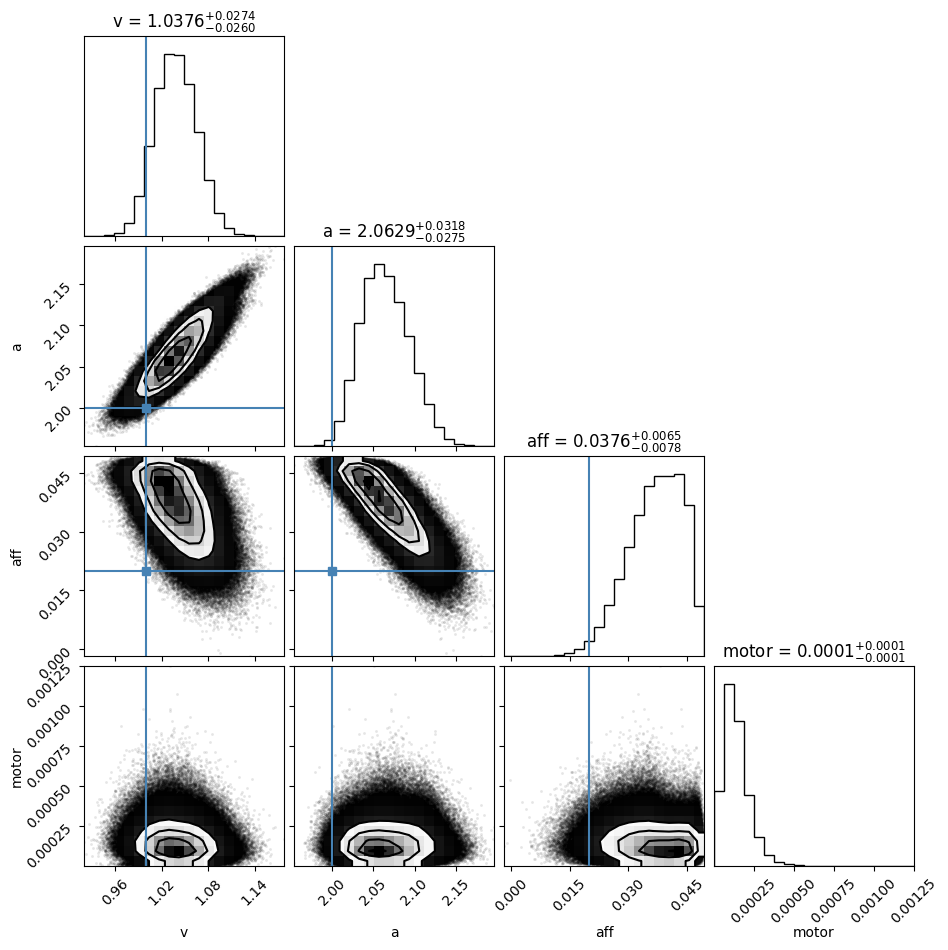

In [11]:
import corner

vp_samples = vp.sample(int(1e6))[0]

v_samples = vp_samples[:,0]
a_samples = vp_samples[:,1]
aff_samples = vp_samples[:,2]
motor_samples = vp_samples[:,3]
param_labels = ['v', 'a', 'aff', 'motor']
true_params = [v, a, aff, motor]
corner.corner(vp_samples, labels=param_labels, show_titles=True, title_fmt=".4f", truths=true_params);
